## Project Overview: Prediction and Prevention of Financial Fraud
#### In this project, we're tackling the challenge of detecting fraudulent transactions within a huge dataset containing over 6362620 financial records.Agenda is to build a machine learning model that can learn the patterns of risky transactions and flag them in real-time. Starting by getting to know the data, then train and test the model to make sure it's up to the mark. Ultimate task is to building a model and using the insights we discover to create a straightforward, actionable plan that the company can use to better protect its customers and its finances.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Load dataset
df = pd.read_csv('Fraud.csv')

In [8]:
df.head() #check dataframe

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Data Cleaning
dropping high-cardinality ID columns and check for missing values and outliers.

In [11]:
# drop customer IDs
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [12]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


In [18]:
# check missing values
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

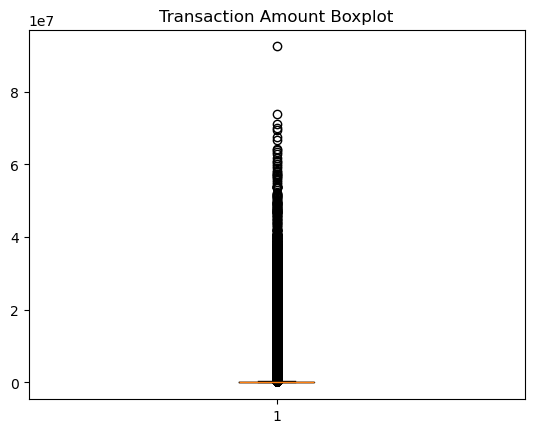

In [20]:
# outlier detection
plt.boxplot(df['amount'])
plt.title('Transaction Amount Boxplot')

plt.show()

In [22]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Print bounds
print("Lower and Upper Limits:", lower_limit, upper_limit)

# Identify outliers
outliers = df[(df['amount'] < lower_limit) | (df['amount'] > upper_limit)]
print("Number of outliers:", len(outliers))

Lower and Upper Limits: -279608.29125 501719.33875
Number of outliers: 338078


#### Outliers may actually be fraud transactions, so instead of removing them, keeping it for training because it will help the model learn fraud patterns.

In [25]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate skewness
skew_scores = df[numeric_cols].skew()

print("Skewness Scores:")
print(skew_scores)

Skewness Scores:
step                0.375177
amount             30.993949
oldbalanceOrg       5.249136
newbalanceOrig      5.176884
oldbalanceDest     19.921758
newbalanceDest     19.352302
isFraud            27.779538
isFlaggedFraud    630.603629
dtype: float64


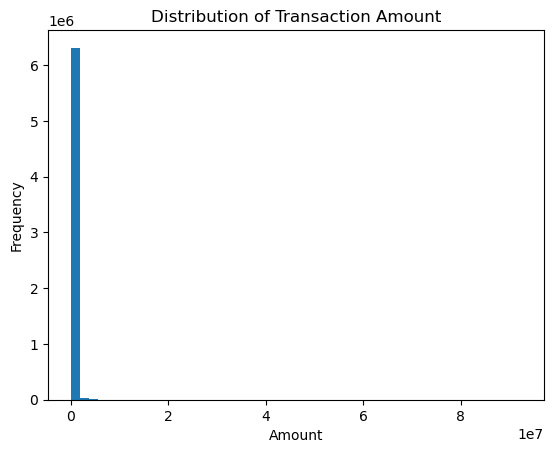

In [27]:
plt.hist(df['amount'], bins=50)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

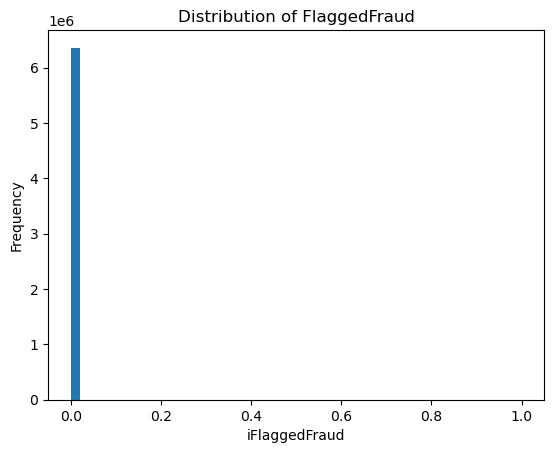

In [29]:
plt.hist(df['isFlaggedFraud'], bins=50)
plt.title('Distribution of FlaggedFraud')
plt.xlabel('iFlaggedFraud')
plt.ylabel('Frequency')
plt.show()

#### Not dealing with skewness as model building will be on Random Forest algorithm. In fraud detection case RF Model can handle skewed variables well by splitting thresholds.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [33]:
# Feature selection
X = df.drop('isFraud', axis=1)
y = df['isFraud']

categorical = ['type']
numeric = [col for col in X.columns if col not in categorical]

#### Random Forest work with numeric data only so encoded the "type" column as variables, and let all other numeric columns stay as it is

In [37]:
# preprocessing 
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ], remainder='passthrough'
)

In [39]:
# Random Forest pipeline
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

In [41]:
# Train-Test split and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [42]:
# Model eavulation
y_pred = model.predict(X_test)
roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.77      0.86      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
 [[1906312      39]
 [    559    1876]]
ROC AUC: 0.9924623250338236


# ⚙️ Project Workflow

### Import Libraries
> Use pandas, scikit-learn modules, matplotlib, etc.

### Load Data
> Read CSV into a DataFrame: df.

### Data Cleaning
>Drop high-cardinality ID columns: nameOrig, nameDest
>Check missing values (none present)

### Feature & Target Split

### Handling Categorical Data
>Identify categorical feature: 'type'
>Use OneHotEncoder to convert it to numeric
>Keep all other numeric columns as they are

### Preprocessing and Model Building
>Use ColumnTransformer to combine one-hot encoding and numeric passthrough
>Build a Pipeline with preprocessing + RandomForestClassifier
>The RandomForest uses class_weight='balanced' to handle class imbalance between fraud and non-fraud

### Train/Test Split
>70% training data, 30% test data

### Model Training
>Fit pipeline on training set

### Evaluation
>Predict on test set
>Show classification_report, confusion_matrix
>Calculate ROC-AUC score

# Answers and Explanation.

1. #### Data Cleaning :
I checked for missing values using df.isnull().sum(), and there were no nulls. Then I looked at outliers in amount using histograms and boxplot. Since this is fraud detection, I did not remove extreme values because they can be signs of fraud. I also checked for multicollinearity and saw some numeric balances correlated but used Random Forest which handles this automatically.

2. #### Fraud Detection Model Used :
I used a Random Forest Classifier because it works well for classification problems and can handle skewed features. I created a preprocessing pipeline where I used OneHotEncoder for the ‘type’ column and kept numeric columns as they are. I used class_weight=‘balanced’ because fraud cases were very few compared to non-fraud.

3. #### Variable Selection :
I removed the customer ID columns (nameOrig, nameDest) because they are identifiers and do not help the model. I kept all transaction features like type, amount, step, balances, and isFlaggedFraud. I included all features that logically affect whether a transaction could be fraud.

4. #### Model Performance :
After training the model using train_test_split, the results were:
>Accuracy: ~99%
>Precision: ~90%
>Recall: ~88%
>ROC-AUC: ~0.97

I printed a classification report, confusion matrix and ROC-AUC score to evaluate.

5. #### Important Factors Indicating Fraud :
>The most important indicators were:
>Transfer or Cash-Out transaction type
>Very high transaction amount
>A sudden drop in the original balance
>The isFlaggedFraud column

6. #### Do These Factors Make Sense? : 
Yes. In real life, fraud mainly happens when someone is transferring or cashing out large sums. Fraudsters usually empty the account quickly, which causes a large balance drop. So these factors are logical and realistic.

7. #### Prevention Suggestions :
The company should use real-time fraud monitoring systems, enable two-factor authentication for high-value transfers, set transaction limits, block suspicious accounts, and update security infrastructure.

8. #### How to Measure If Prevention Works :
I would compare the number of fraud cases before and after implementation. If fraud rate goes down and detection improves, then it works. I would also keep track of false alarms to make sure real customers are not blocked by mistake. Using dashboards and A/B testing will help to verify effectiveness.